This notebook determines the cost of various requirements. It is based on the measures as stored in a VRTOOL database.
The figures generated have been used in the Handreiking Veiligheidsrendement.

In [1]:
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
import numpy as np
from scipy.stats import norm
from peewee import fn
import itertools
from vrtool.orm.models import *
from vrtool.orm.orm_controllers import open_database
from vrtool.common.enums import MechanismEnum
from postprocessing.common_functions.database_analytics import *
from postprocessing.common_functions.database_access_functions import * 

from postprocessing.common_functions.vrtool_optimization_object import VRTOOLOptimizationObject
from postprocessing.common_functions.vrtool_measures_object import VRTOOLMeasuresObject
from postprocessing.common_functions.uniform_requirements_analysis import UniformRequirementsAnalysis

from postprocessing.common_functions.generate_output import *
import matplotlib.pyplot as plt

from common_functions.Deltares_colors import Deltares_colors 
sns.set(style="whitegrid")
colors =  Deltares_colors().sns_palette("DeltaresFull")

In [26]:
# root_dir = Path(r"c:\Users\klerk_wj\OneDrive - Stichting Deltares\00_Projecten\11_VR_HWBP\05_Handreiking\casus_ontwerpen\38-1\N=4 database")
root_dir = Path(r"n:\Projects\11209000\11209353\B. Measurements and calculations\008 - Resultaten Proefvlucht\Alle_Databases")
# db_path = root_dir.joinpath("38-1","38-1_basis.db")
db_path = root_dir.joinpath("met lengte-effecten (N=4)","10-1","database_10-1_trajectaanpak.sqlite")

has_revetment = False
design_year = 50
LE = 4 # ['no', 4, 'full'] 

_runs_overview = get_overview_of_runs(db_path)
_runs_overview

save_dir = Path(r'c:\Users\klerk_wj\OneDrive - Stichting Deltares\00_Projecten\11_VR_HWBP\05_Handreiking\casus_ontwerpen\vergelijkingen_uniforme_kansen')

We load the measures and import them into the object for analyzing requirements.

In [27]:
measure_set = VRTOOLMeasuresObject(db_path, LE_scenario=LE, design_year=50)
uniform_requirements = UniformRequirementsAnalysis(measure_set)



Now we can determine the cost of measures for each mechanism for a certain omega space

Text(0.5, 1.0, '10-1')

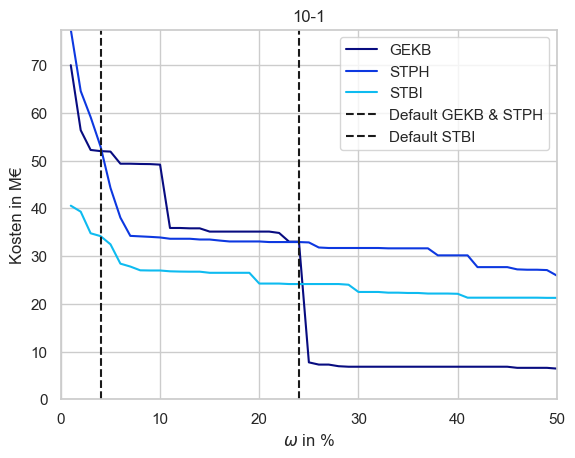

In [28]:
#relation between omega and cost for overflow
omega_values = np.arange(0.01, 0.51, 0.01)
cost_values_overflow = []
cost_values_piping = []
cost_values_stability = []
N_LE_piping = uniform_requirements.traject_length * uniform_requirements.a_piping / uniform_requirements.b_piping
N_LE_stability = uniform_requirements.traject_length * uniform_requirements.a_stability_inner / uniform_requirements.b_stability_inner
for omega in omega_values:
    beta_t = pf_to_beta(np.multiply(uniform_requirements.p_max, omega))
    results = uniform_requirements.calculate_cost(beta_t, pf_to_beta(1./10), pf_to_beta(1./10), uniform_requirements.measures)
    cost_values_overflow.append(results[0]/1e6)

    #relation between omega and cost for piping
    beta_t = pf_to_beta(np.multiply(uniform_requirements.p_max, omega)/N_LE_piping)
    results = uniform_requirements.calculate_cost(pf_to_beta(1./10), beta_t, pf_to_beta(1./10), uniform_requirements.measures)
    cost_values_piping.append(results[0]/1e6)

    #relation between omega and cost for stability
    beta_t = pf_to_beta(np.multiply(uniform_requirements.p_max, omega)/N_LE_stability)
    results = uniform_requirements.calculate_cost(pf_to_beta(1./10), pf_to_beta(1./10), beta_t, uniform_requirements.measures)
    cost_values_stability.append(results[0]/1e6)


fig, ax = plt.subplots()
ax.plot(omega_values* 100, cost_values_overflow, color = colors[0], label = 'GEKB')
ax.plot(omega_values* 100, cost_values_piping, color = colors[1], label = 'STPH')
ax.plot(omega_values* 100, cost_values_stability, color = colors[2], label = 'STBI')
ax.vlines(0.24*100, 0, max(max(cost_values_overflow), max(cost_values_piping), max(cost_values_stability)), colors='k', linestyles='dashed', label='Default GEKB & STPH')
ax.vlines(0.04*100, 0, max(max(cost_values_overflow), max(cost_values_piping), max(cost_values_stability)), colors='k', linestyles='dashed', label='Default STBI')


ax.set_ylabel('Kosten in M€')
ax.set_xlabel(r'$\omega$ in %')
ax.set_xlim(left = 0, right = 50)
ax.set_ylim(bottom = 0, top = max(max(cost_values_overflow), max(cost_values_piping), max(cost_values_stability)))
ax.legend()
ax.set_title(DikeTrajectInfo.get(DikeTrajectInfo.id == 1).traject_name)
# plt.savefig(save_dir.joinpath(f'{DikeTrajectInfo.get(DikeTrajectInfo.id == 1).traject_name}_omega_kosten.png'), dpi=300, bbox_inches='tight')




We can do the same for the length-effect factor for piping and stability. First we need to ensure that only the relevant measures are considered. So we set beta to 8 for the others.

In [29]:
measures_piping = uniform_requirements.measures.copy()
measures_piping['StabilityInner_dsn'] = 8.0
measures_piping['StabilityInner'] = 8.0
measures_piping['Overflow_dsn'] = 8.0
measures_piping['Overflow'] = 8.0

measures_stability = uniform_requirements.measures.copy()
measures_stability['Piping_dsn'] = 8.0
measures_stability['Piping'] = 8.0
measures_stability['Overflow_dsn'] = 8.0
measures_stability['Overflow'] = 8.0

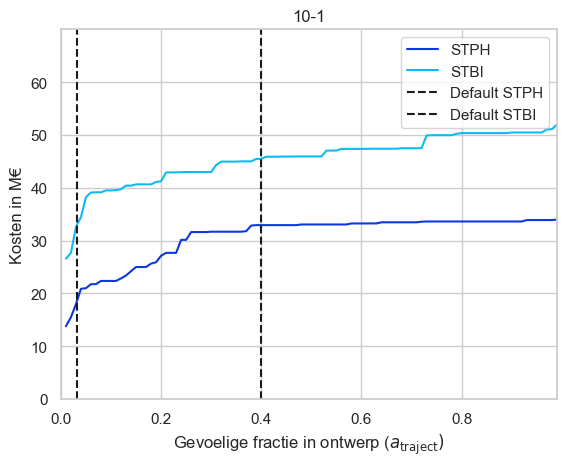

In [30]:
#relation between a and cost for overflow
a_values = np.arange(0.01, 1.0, 0.01)
cost_values_piping = []
cost_values_stability = []
pf_traject_piping = []
pf_traject_stability = []

for a_value in a_values:
    #relation between a and cost for piping
    beta_t = pf_to_beta(np.multiply(np.multiply(uniform_requirements.p_max, .24), uniform_requirements.b_piping/np.multiply(a_value, uniform_requirements.traject_length)))
    results = uniform_requirements.calculate_cost(pf_to_beta(1./10), beta_t, pf_to_beta(1./10), measures_piping)
    cost_values_piping.append(results[0]/1e6)
    pf_traject_piping.append(results[1])


    #relation between a and cost for stability
    beta_t = pf_to_beta(np.multiply(np.multiply(uniform_requirements.p_max, .04), uniform_requirements.b_stability_inner/np.multiply(a_value, uniform_requirements.traject_length)))
    results = uniform_requirements.calculate_cost(pf_to_beta(1./10), pf_to_beta(1./10), beta_t, measures_stability)
    cost_values_stability.append(results[0]/1e6)
    pf_traject_stability.append(results[1])

fig, ax = plt.subplots()
ax.plot(a_values, cost_values_piping, color = colors[1], label = 'STPH')
ax.plot(a_values, cost_values_stability, color = colors[2], label = 'STBI')
ax.vlines(uniform_requirements.a_piping, 0, max(max(cost_values_overflow), max(cost_values_piping), max(cost_values_stability)), colors='k', linestyles='dashed', label='Default STPH')
ax.vlines(uniform_requirements.a_stability_inner, 0, max(max(cost_values_overflow), max(cost_values_piping), max(cost_values_stability)), colors='k', linestyles='dashed', label='Default STBI')


ax.set_ylabel('Kosten in M€')
ax.set_xlabel(r'Gevoelige fractie in ontwerp ($a_{\text{traject}})$')
ax.set_xlim(left = 0, right = max(a_values))
ax.set_ylim(bottom = 0, top = max(max(cost_values_overflow), max(cost_values_piping), max(cost_values_stability)))
ax.legend()
ax.set_title(DikeTrajectInfo.get(DikeTrajectInfo.id == 1).traject_name)

plt.savefig(save_dir.joinpath(f'{DikeTrajectInfo.get(DikeTrajectInfo.id == 1).traject_name}_a_vs_kosten_N={LE}.png'), dpi=300, bbox_inches='tight')


Next we can make a plot where we compare the LE to the expected values

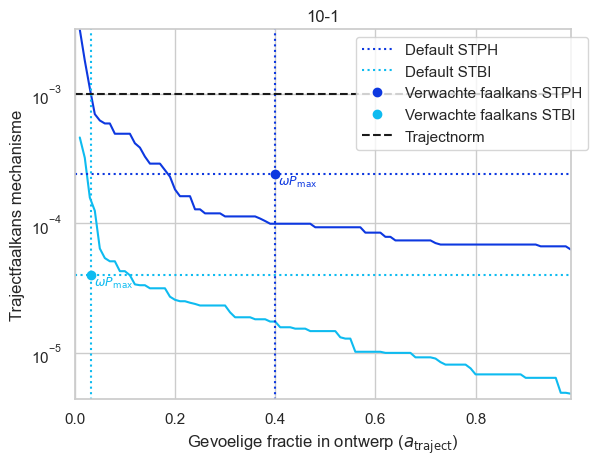

In [31]:
fig, ax = plt.subplots()
ax.plot(a_values, pf_traject_piping, color=colors[1])
ax.plot(a_values, pf_traject_stability, color = colors[2])
# ax.plot(a_values, np.add(pf_traject_stability,pf_traject_piping), color = colors[6])

ax.set_ylabel('Trajectfaalkans mechanisme')
ax.set_xlabel(r'Gevoelige fractie in ontwerp ($a_{\text{traject}}$)')
ax.set_xlim(left = 0, right= max(a_values))
ax.set_ylim(bottom = min(min(pf_traject_piping), min(pf_traject_stability))/1.1, top = max(max(pf_traject_piping), max(pf_traject_stability)))
ax.set_yscale('log')
ax.vlines(uniform_requirements.a_piping, 0, max(max(pf_traject_piping), max(pf_traject_stability)), colors=colors[1], linestyles='dotted', label='Default STPH')
ax.vlines(uniform_requirements.a_stability_inner, 0, max(max(pf_traject_piping), max(pf_traject_stability)), colors=colors[2], linestyles='dotted', label='Default STBI')

ax.hlines(0.24*uniform_requirements.p_max, 0, max(a_values), colors=colors[1], linestyles='dotted')
ax.hlines(0.04*uniform_requirements.p_max, 0, max(a_values), colors=colors[2], linestyles='dotted')
# ax.hlines(0.28*p_max, 0, max(a_values), colors=colors[6], linestyles='dotted', label='Faalkansruimte samen')
ax.plot(uniform_requirements.a_piping, 0.24*uniform_requirements.p_max, color=colors[1], marker='o', linestyle = '', label='Verwachte faalkans STPH')
ax.text(uniform_requirements.a_piping, 0.24*uniform_requirements.p_max, r' $\omega P_\mathrm{max}$', 
        fontsize = 9 , color=colors[1], horizontalalignment='left', verticalalignment='top')
ax.plot(uniform_requirements.a_stability_inner, 0.04*uniform_requirements.p_max, color=colors[2], marker='o', linestyle = '', label='Verwachte faalkans STBI')
ax.text(uniform_requirements.a_stability_inner, 0.04*uniform_requirements.p_max, r' $\omega P_\mathrm{max}$', 
        fontsize = 9 , color=colors[2], horizontalalignment='left', verticalalignment='top')
ax.hlines(uniform_requirements.p_max, 0, max(a_values), colors='k', linestyles='dashed', label='Trajectnorm')
ax.set_title(DikeTrajectInfo.get(DikeTrajectInfo.id == 1).traject_name)
ax.legend(bbox_to_anchor=(1.05, 1))
plt.savefig(save_dir.joinpath(f'{DikeTrajectInfo.get(DikeTrajectInfo.id == 1).traject_name}_a_vs_pf_N={LE}.png'), dpi=300, bbox_inches='tight')


Stel we willen puur een piping of stabiliteitsopgave oplossen, we gaan uit van standaard waarden. Hoe is dan de faalkans/n/beta over de vakken verdeeld?

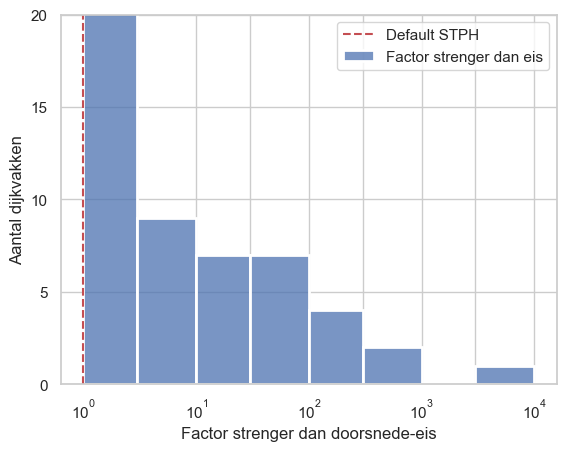

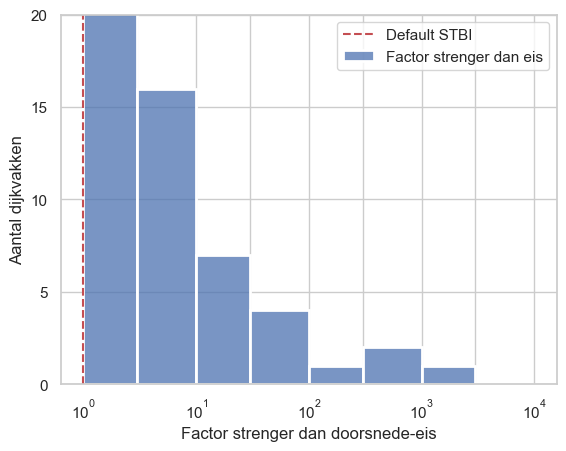

In [24]:
beta_t = pf_to_beta(uniform_requirements.p_max * uniform_requirements.omega_piping * (uniform_requirements.b_piping / (uniform_requirements.a_piping * uniform_requirements.traject_length)))
results = uniform_requirements.calculate_cost(pf_to_beta(1./10), beta_t, pf_to_beta(1./10), measures_piping)
piping_betas = results[2].Piping_dsn
binrange = [1, 3, 10, 30, 100, 300, 1000, 3000, 10000]

fig, ax = plt.subplots()
sns.histplot(beta_to_pf(beta_t)/beta_to_pf(piping_betas), bins = binrange, ax = ax, label= 'Factor strenger dan eis', linewidth= 2)
ax.vlines(1, 0, 100, colors='r', linestyles='dashed', label='Default STPH')
ax.set_xlabel('Factor strenger dan doorsnede-eis')
ax.set_ylabel('Aantal dijkvakken')
ax.set_ylim(top=20)
ax.set_xscale('log')
ax.set_xticks(binrange)
ax.set_yticks([0, 5, 10, 15, 20])
ax.legend()

#same for STBI
beta_t = pf_to_beta(uniform_requirements.p_max * uniform_requirements.omega_stability_inner * (uniform_requirements.b_stability_inner / (uniform_requirements.a_stability_inner * uniform_requirements.traject_length)))
results = uniform_requirements.calculate_cost(pf_to_beta(1./10), pf_to_beta(1./10), beta_t, measures_stability)
stability_betas = results[2].StabilityInner_dsn

fig, ax = plt.subplots()
sns.histplot(beta_to_pf(beta_t)/beta_to_pf(stability_betas), bins = binrange, ax = ax, label= 'Factor strenger dan eis', linewidth=2)
ax.vlines(1, 0, 100, colors='r', linestyles='dashed', label='Default STBI')
ax.set_xlabel('Factor strenger dan doorsnede-eis')
ax.set_ylabel('Aantal dijkvakken')
ax.set_ylim(top=20)
ax.set_xscale('log')
ax.set_xticks(binrange)
ax.set_yticks([0, 5, 10, 15, 20])

ax.legend()
